In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import re
%matplotlib inline

In [98]:
def parse_results_from_file(file_name):

    poly_modulus_regex = r'.*poly_modulus: (.*)'
    load_model_regex = r'.*sw_load_model: (.*)ms'
    encrypt_input_regex = r'.*sw_encrypt_input: (.*)ms'
    run_model_regex = r'.*sw_run_model: (.*)ms'
    decrypt_output_regex = r'.*sw_decrypt_output: (.*)ms'
    global_regex = r'.*sw_global: (.*)ms'
    batch_size_regex = r'.*of (.*) elements'

    runtimes = {8192: [], 16384: []}
    poly_modulus = None
    load_model = None
    encrypt_input = None
    run_model = None
    decrypt_output = None
    global_time = None
    batch_size = None

    batch_size_count = 0
    with open(file_name) as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            if re.match(poly_modulus_regex, line):
                match = re.match(poly_modulus_regex, line)
                poly_modulus = int(match.groups()[0])
            elif re.match(load_model_regex, line):
                match = re.match(load_model_regex, line)
                load_model = int(match.groups()[0])  
            elif re.match(encrypt_input_regex, line):
                match = re.match(encrypt_input_regex, line)
                encrypt_input = int(match.groups()[0])  
            elif re.match(run_model_regex, line):
                match = re.match(run_model_regex, line)
                run_model = int(match.groups()[0])
            elif re.match(decrypt_output_regex, line):
                match = re.match(decrypt_output_regex, line)
                decrypt_output = int(match.groups()[0])
            elif re.match(global_regex, line):
                match = re.match(global_regex, line)
                global_time = int(match.groups()[0])
            elif re.match(batch_size_regex, line):
                match = re.match(batch_size_regex, line)
                batch_size = int(match.groups()[0])

                batch_size_count += 1

                # Skip warmup:
                if batch_size_count > 1:
                    runtimes[poly_modulus].append((batch_size, encrypt_input, run_model, decrypt_output, global_time))
                    
    return runtimes

In [105]:
all_results = []

# Read exp_0.txt, exp_1.txt, ..., exp_9.txt
file_names = ['exp13_%s.txt' % i for i in range(10)]
for file_name in file_names:
    results_from_file = parse_results_from_file(file_name)
    all_results.append(results_from_file)

batch_sizes = [2**n for n in range(13)]

avg_results = {}
for n in [8192]: # [16384]
    avg_results[n] = []
    for batch_ind, batch_size in enumerate(batch_sizes):
        results_sum = (0, 0, 0, 0, 0)
        for result in all_results:
            results_sum = tuple(map(sum, zip(results_sum, result[n][batch_ind][1:])))        
        results_avg = tuple([batch_size] + [float(x) / len(all_results) for x in results_sum])
        avg_results[n].append(results_avg)  

print(avg_results[8192])

[(1, 194.4, 24520.4, 136.2, 24939.4), (2, 221.6, 24102.0, 122.0, 24535.6), (4, 212.6, 23826.2, 129.3, 24259.4), (8, 206.9, 23715.1, 114.8, 24128.4), (16, 197.8, 23759.3, 124.3, 24171.5), (32, 202.8, 23731.9, 132.3, 24156.3), (64, 216.0, 23847.3, 124.1, 24277.0), (128, 218.0, 23753.2, 130.1, 24192.3), (256, 216.5, 23798.9, 130.2, 24234.0), (512, 212.0, 23627.9, 119.7, 24056.6), (1024, 202.5, 23666.7, 115.5, 24075.4), (2048, 232.3, 23464.1, 125.9, 23911.9), (4096, 205.4, 23429.6, 120.3, 23844.2)]


# Encryption

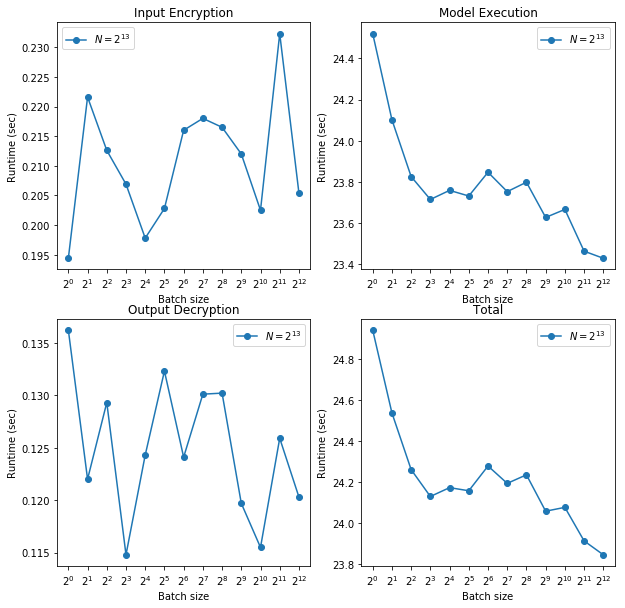

In [106]:
batch_sizes = [2 ** x for x in range(13)]

plt.figure(figsize=(10,10))
plt.subplot(221)

plt.plot([pt[0] for pt in avg_results[8192]], [pt[1]/1000. for pt in avg_results[8192]], 'o-', label='$N=2^{13}$')
plt.title('Input Encryption')
plt.ylabel('Runtime (sec)')
plt.xlabel('Batch size')
plt.xscale('log', basex=2)
plt.xticks(batch_sizes)
plt.legend()

plt.subplot(222)
plt.plot([pt[0] for pt in avg_results[8192]], [pt[2]/1000. for pt in avg_results[8192]], 'o-', label='$N=2^{13}$')
plt.title('Model Execution')
plt.ylabel('Runtime (sec)')
plt.xlabel('Batch size')
plt.xscale('log', basex=2)
plt.xticks(batch_sizes)
plt.legend()

plt.subplot(223)
plt.plot([pt[0] for pt in avg_results[8192]], [pt[3]/1000. for pt in avg_results[8192]], 'o-', label='$N=2^{13}$')
plt.title('Output Decryption')
plt.ylabel('Runtime (sec)')
plt.xlabel('Batch size')
plt.xscale('log', basex=2)
plt.xticks(batch_sizes)
plt.legend()

plt.subplot(224)
plt.plot([pt[0] for pt in avg_results[8192]], [pt[4]/1000. for pt in avg_results[8192]], 'o-', label='$N=2^{13}$')
plt.title('Total')
plt.ylabel('Runtime (sec)')
plt.xlabel('Batch size')
plt.xscale('log', basex=2)
plt.xticks(batch_sizes)
plt.legend()